# Idee 1: The lazy mans way

Trainiere 10 VAE, jeweils mit den Samples einer Klasse von MNIST. Wir haben dann 10 VAE, jeder spezialisiert auf die Generierung einer Zahl. Immer wenn wir eine Zahl generieren müssen, benutzen wir dafür den jeweiligen speizialisierten VAE.

# Idee 2: Wie auf dem Zettel vorgeschlagen mithilfe von Conditional Variational Autencodern (CVAE)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import multiprocessing 

In [2]:
if torch.cuda.is_available():
    device = "cuda"
    print("Training on gpu")
else:
    device = "cpu"
    print("Training on cpu")

Training on gpu


In [3]:
def to_onehot(digits, num_classes, device):
    """ [[3]] => [[0, 0, 1]]
    """
    labels_onehot = torch.zeros(digits.shape[0], num_classes).to(device)
    labels_onehot.scatter_(1, digits.view(-1, 1), 1)
    return labels_onehot



class CCVAE(nn.Module):
    """ Conditional convolutional variational autoencoder.
    """
    def __init__(self, input_channels, lat_dim, num_classes, device):
        super().__init__()
        self.conv1_ds = nn.Conv2d(input_channels + num_classes, 16, kernel_size=(3, 3), stride=(2,2), padding=1)
        self.conv2_ds = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.conv3_ds = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.dense_enc_mean = nn.Linear(4 * 4 * 64, lat_dim)
        self.dense_enc_std = nn.Linear(4 * 4 *64, lat_dim)
        self.dense_dec = nn.Linear(lat_dim + num_classes, 4 * 4 * 64)
        self.deconv_3 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.deconv_2 = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.deconv_1 = nn.ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.lat_dim = lat_dim
        self.num_classes = num_classes
        self.device = device

    def encode(self, x, y):
        """ The next 5 lines of code were taken from https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-cnn-cvae_no-out-concat.ipynb
        since it was the only reference on how to use a conditional variational autencoder with convolutions that we found on the internet
        What we do is add num_classes channels to the input, where we set the channel corresponding to the correct class 
        to have only ones and the rest of the channels to have only zeros
        """
        y_onehot = to_onehot(y, self.num_classes, self.device)
        y_onehot = y_onehot.view(-1, self.num_classes, 1, 1)
        ones = torch.ones(x.shape[0], 
                          self.num_classes,
                          x.shape[2], 
                          x.shape[3], 
                          dtype=x.dtype).to(self.device)
        ones = ones * y_onehot
        x = torch.cat((x, ones), dim=1)
        
        x = self.conv1_ds(x)
        x = nn.functional.relu(x)
        x = self.conv2_ds(x)
        x = nn.functional.relu(x)
        x = self.conv3_ds(x)
        x = nn.functional.relu(x)
        x = torch.flatten(x, 1)
        mean, std = self.dense_enc_mean(x), self.dense_enc_std(x)
        return mean, std
        
    def decode(self, x, y):
        """ Just append the one hot vector as features
        """
        y_onehot = to_onehot(y, self.num_classes, self.device)
        x = torch.cat((x, y_onehot), dim=1)
        
        x = self.dense_dec(x)
        x = nn.functional.relu(x)
        x = torch.reshape(x, (x.shape[0], 64, 4, 4))
        x = self.deconv_3(x)
        x = nn.functional.relu(x)
        x = self.deconv_2(x)
        x = nn.functional.relu(x)
        x = self.deconv_1(x)
        """ Trick to make sure all outputs are in range (0, 1)
        """
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x, y):
        mean, std = self.encode(x, y)
        latent = self.reparameterize(mean, std)
        out = self.decode(latent, y)
        return out, mean, std
        
    def reparameterize(self, mean, std):
        eps = torch.randn_like(mean).to(self.device)
        return eps * std + mean

    def generate(self, y):
        with torch.no_grad():
            eps = torch.randn((y.shape[0], self.lat_dim)).to(self.device)
            return self.decode(eps, y)
        
def kl_divergence(mean, std):
    variance = std.pow(2)
    inner = mean.pow(2) + variance - 1 - torch.log(variance)
    return (1/2) * torch.sum(inner)

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

dataset = torch.utils.data.ConcatDataset((trainset, testset))
ds_loader = torch.utils.data.DataLoader(dataset, batch_size=128, 
                                         shuffle=True, num_workers=multiprocessing.cpu_count())

In [4]:
generator = CCVAE(1, 50, num_classes=10, device=device).to(device)

In [5]:
num_epochs = 60
bce_loss = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0005)

rec_losses = []
kl_losses = []
generator.train()
for epoch in range(1, num_epochs + 1):
    running_rec_loss = 0
    running_kl_loss = 0
    iterations = 0
    for x, y in ds_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        reconstruction, mean, std = generator(x, y)
        reconstruction = reconstruction.view(x.shape[0], -1)
        x = x.view(x.shape[0], -1)
        reconstruction_loss = bce_loss(reconstruction, x)
        kl_loss = kl_divergence(mean, std)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()
        running_rec_loss += loss.item()
        running_kl_loss += kl_loss.item()
        iterations += 1
        
    rec_loss = running_rec_loss / iterations
    kl_loss = running_kl_loss / iterations
    rec_losses.append(rec_loss)
    kl_losses.append(kl_loss)
    print(f"Epoch {epoch}/{num_epochs} ==> rec_loss: {rec_loss}, kl_loss: {kl_loss}, total: {rec_loss + kl_loss}")

Epoch 1/60 ==> rec_loss: 30081.75284934872, kl_loss: 1787.6272702400165, total: 31869.380119588735
Epoch 2/60 ==> rec_loss: 18083.442659534965, kl_loss: 2107.2823285481177, total: 20190.724988083082
Epoch 3/60 ==> rec_loss: 15634.292597406307, kl_loss: 2523.298676373972, total: 18157.59127378028
Epoch 4/60 ==> rec_loss: 14612.496759669219, kl_loss: 2639.2583945098263, total: 17251.755154179045
Epoch 5/60 ==> rec_loss: 14054.153850548446, kl_loss: 2700.7078060728977, total: 16754.861656621342
Epoch 6/60 ==> rec_loss: 13707.16146309415, kl_loss: 2735.9358262754226, total: 16443.097289369573
Epoch 7/60 ==> rec_loss: 13471.554119772623, kl_loss: 2749.112643003028, total: 16220.66676277565
Epoch 8/60 ==> rec_loss: 13313.576966336266, kl_loss: 2760.7806059507825, total: 16074.357572287048
Epoch 9/60 ==> rec_loss: 13178.048190770682, kl_loss: 2759.7957440085124, total: 15937.843934779194
Epoch 10/60 ==> rec_loss: 13083.234930230234, kl_loss: 2761.7314966400536, total: 15844.966426870287
Epoch

[]

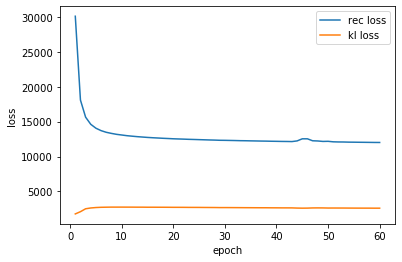

In [6]:
plt.plot(list(range(1, len(rec_losses)  + 1)), rec_losses, label="rec loss")
plt.plot(list(range(1, len(kl_losses)  + 1)), kl_losses, label="kl loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.plot()

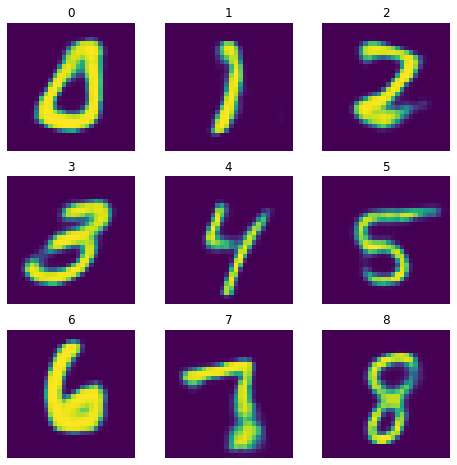

In [7]:
generator.eval()
classes = torch.cuda.LongTensor(list(range(10)))
samples = generator.generate(classes).cpu().numpy()

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

for col in range(ax.shape[1]):
    for row in range(ax.shape[0]):
        img = samples[col + row * 3]
        ax[row][col].imshow(img.reshape((28, 28)))
        ax[row][col].set_title(col + row * 3)
        ax[row][col].axis('off')

In [8]:
def get_digit(number, n_th_digit): 
    return number // 10 ** n_th_digit % 10

digits = 20
pi = np.pi

digits = [int(get_digit(pi, n_th_digit)) for n_th_digit in range(0, -20, -1)]
classes = torch.cuda.LongTensor(digits)

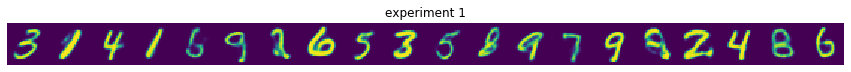

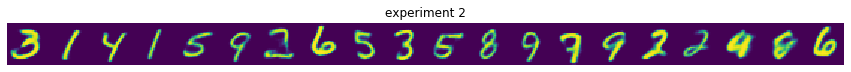

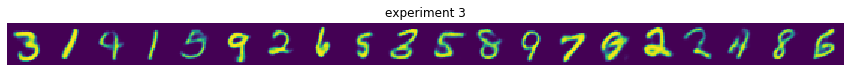

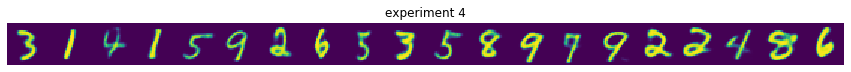

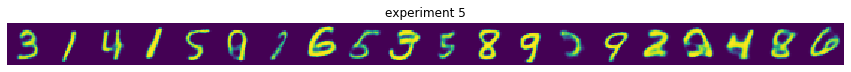

In [9]:
for experiment in range(1, 6):
    samples = generator.generate(classes).cpu().numpy()
    samples = samples.reshape((-1, 28, 28))
    samples_stacked = np.hstack(tuple(samples))
    plt.figure(figsize=(15, 15))
    plt.imshow(samples_stacked)
    plt.title(f"experiment {experiment}")
    plt.axis('off')
    plt.show()